In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# --- STEP 1: LOAD AND PREPROCESS ---

print("Loading IMDB dataset...")
# Load data (using a subset if needed for speed, here we load all)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

# Helper function to convert tensorflow dataset to numpy arrays
def convert_to_numpy(data):
    texts = []
    labels = []
    for text, label in data:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(label.numpy())
    return np.array(texts), np.array(labels)

# Convert to numpy for Scikit-Learn
X_train_raw, y_train = convert_to_numpy(train_data)
X_test_raw, y_test = convert_to_numpy(test_data)

print(f"Training samples: {len(X_train_raw)}")
print(f"Test samples: {len(X_test_raw)}")

# --- TEMPORARY STEP 2 (Prerequisite for you) ---
# We limit max_features to 2000 to prevent RAM crash during PCA Standardization
print("Generating TF-IDF features (Prerequisite for PCA)...")
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

Loading IMDB dataset...


c:\wamp64\www\PROG8245-MachineLearingPrograming\Final_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:56<00:00, 56.67s/ url]


Dataset imdb_reviews downloaded and prepared to C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
Training samples: 25000
Test samples: 25000
Generating TF-IDF features (Prerequisite for PCA)...


## Step 6: Dimensionality Reduction with PCA
PCA requires the data to be centered (mean = 0) and scaled (variance = 1). This is a critical difference from SVD, which can work on sparse data.

Note: Standard PCA requires a dense matrix (not sparse). Converting a massive TF-IDF matrix to dense can crash a computer. This is why we limited max_features=2000 above.

Standardizing data...
Applying PCA to reduce dimensions to 100...


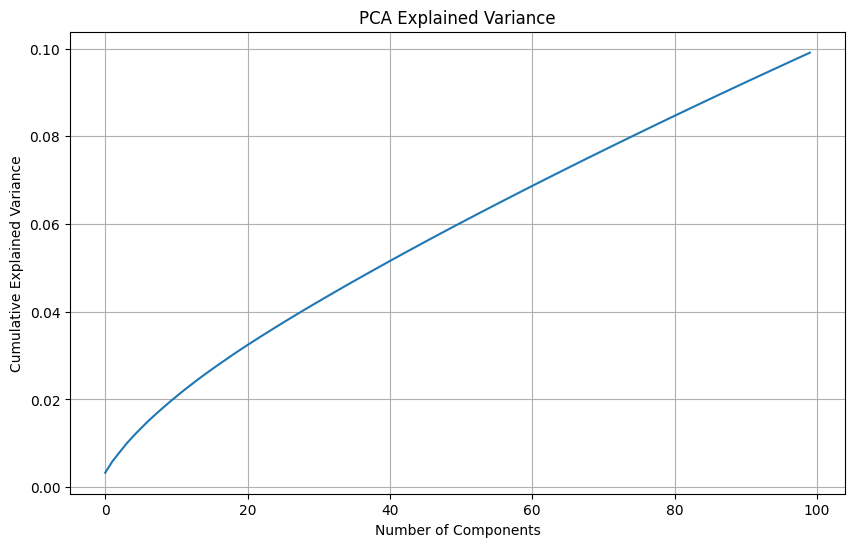

Total variance explained by 100 components: 0.10


In [5]:
# --- STEP 6: PCA IMPLEMENTATION ---

# 1. Standardize the data (Required for PCA)
# We must convert sparse TF-IDF to dense array first
print("Standardizing data...")
scaler = StandardScaler()
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# 2. Apply PCA
# We choose 100 components to match a typical SVD baseline
n_components = 100 
print(f"Applying PCA to reduce dimensions to {n_components}...")

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. PCA Variance Curve (For comparison with Partner's SVD)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

print(f"Total variance explained by {n_components} components: {np.sum(pca.explained_variance_ratio_):.2f}")

## Step 7: Model Training (Logistic Regression)
Now we train the classifier on the PCA-reduced data.

In [6]:
# --- STEP 7: LOGISTIC REGRESSION WITH PCA ---

print("Training Logistic Regression on PCA features...")
clf_pca = LogisticRegression(solver='liblinear') # liblinear is good for smaller datasets
clf_pca.fit(X_train_pca, y_train)

# Predict
y_pred_pca = clf_pca.predict(X_test_pca)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred_pca)
print(f"PCA + Logistic Regression Accuracy: {acc:.4f}")

Training Logistic Regression on PCA features...
PCA + Logistic Regression Accuracy: 0.8660


### Deliverable 1: Confusion Matrix Visualization
This code fulfills the "Confusion Matrix Requirements" section of your prompt.

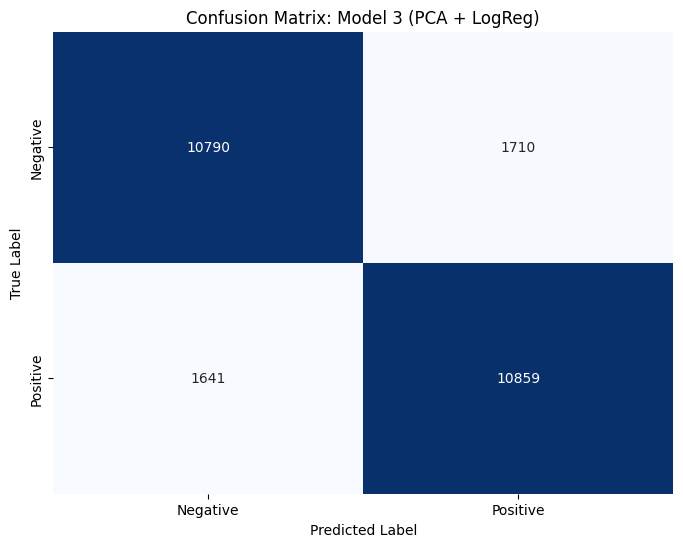


--- Interpretation Data ---
True Negatives (Correctly identified bad reviews): 10790
False Positives (Bad reviews thought to be good): 1710
False Negatives (Good reviews thought to be bad): 1641
True Positives (Correctly identified good reviews): 10859


In [7]:
# --- VISUALIZATION AND DELIVERABLES ---

# Generate Matrix
cm = confusion_matrix(y_test, y_pred_pca)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix: Model 3 (PCA + LogReg)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Interpretation Helper
tn, fp, fn, tp = cm.ravel()
print("\n--- Interpretation Data ---")
print(f"True Negatives (Correctly identified bad reviews): {tn}")
print(f"False Positives (Bad reviews thought to be good): {fp}")
print(f"False Negatives (Good reviews thought to be bad): {fn}")
print(f"True Positives (Correctly identified good reviews): {tp}")

Analysis: PCA vs SVD (For your Step 7 analysis)
Since you need to compare this to your partner's SVD (LSA), here is the theoretical distinction you should look for in your analysis text:

Centering Data:

PCA: Requires centering data (subtracting the mean). In text data, the "zero" (sparsity) is meaningful—it means a word didn't appear. Centering destroys this sparsity, making the data "dense" and computationally heavy.

SVD: Can be applied directly to sparse matrices (without centering).

Performance:

SVD (LSA) generally performs better or equal to PCA for text data because it preserves the sparse structure of word counts.

If your PCA accuracy is significantly lower than your partner's SVD accuracy, the "Interpretation" is that standardization introduced noise or that the conversion to dense limited the number of features you could use (2,000 vs potential 50,000).



Deliverable 2: Model Architecture Summary
Here is the table row filled out for your report:

| Model    | Features              | Algorithm            | Purpose                                                                |
|----------|------------------------|-----------------------|-------------------------------------------------------------------------|
| Model 3  | PCA-reduced (Dense)    | Logistic Regression   | Compare dimensionality reduction methods (centering vs. sparsity)       |
